In [1]:
#leapfrog 実装はここから引用
#https://kefism.hatenablog.com/entry/2017/03/14/231005

import autograd.numpy as np
from autograd import grad, jacobian, elementwise_grad
import matplotlib.pyplot as plt


# 運動エネルギー
def momentum(p):
    return  np.sum(p**2)
#導関数はautogradを使って導出
d_momentum=jacobian(momentum)


# リープ・フロッグ法を事項する関数(今回の実験ではepsilon(ステップサイズ)を小さくして、誤差にかんして余り気にしないで解析)
def leapflog( q,p ,epsilon=0.04):
    q=np.copy(q)
    p=np.copy(p)
    q += -0.5*epsilon*(-d_momentum(p))
    p += epsilon*d_log_prob(q,)
    q += -epsilon*(-d_momentum(p))
    return q, p

d_log_prob=None
log_prob=None

#leapFrogの軌道をつくるモデルパラメータqが指定されてなければ、乱数で作る＝新しいchainの開始
#qが指定されていればそれを引き継いでモーメンタム項だけを乱数サンプリング
def make_traj(q=None):
    if(q is None):q=np.random.randn(2)
    p=np.random.randn(2)
    qs=[q]
    ps=[p]
    for i in range(20):#軌道の長さ（HMCのstep数)
        for j in range(3):#軌道を全部プロットすると重いので少し飛ばしてる
            q,p=leapflog(q,p)
        qs.append(q)
        ps.append(p)
    ps=np.array(ps)
    qs=np.array(qs)
    return qs,ps
#ハミルトニアン（https://arxiv.org/pdf/1701.02434.pdfの解説でいうlevel setだったりエネルギーEだったり ）
def H(p,q):
    return log_prob(q)-momentum(p)


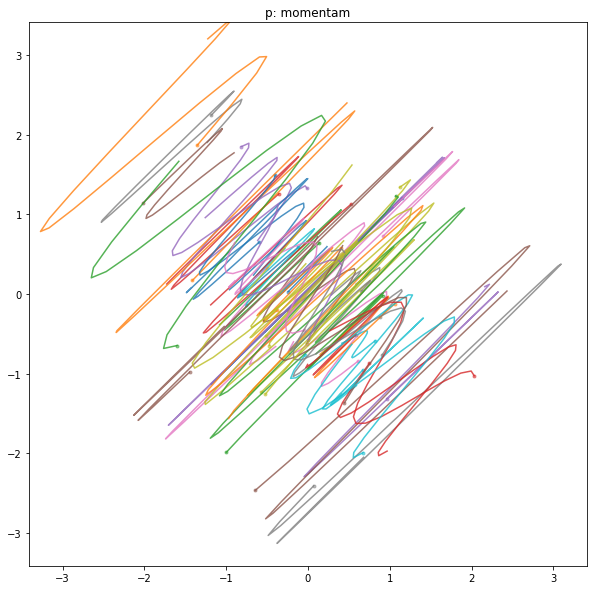

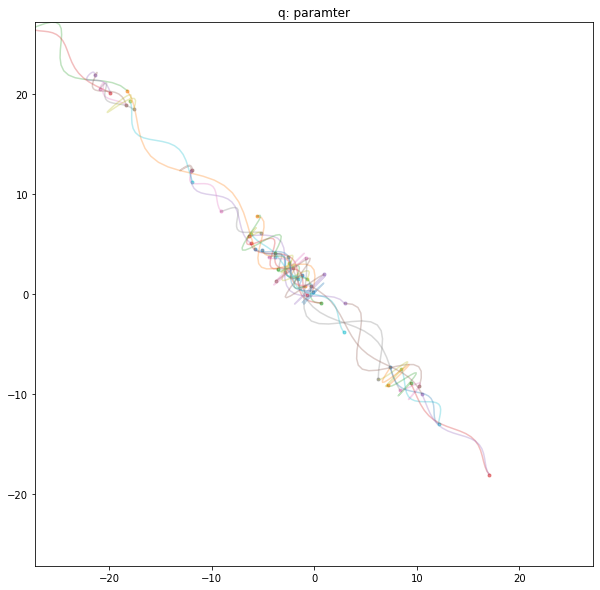

In [9]:
#モデル関数の分布を歪ませるためのマトリックス
M=np.array([[1,0],[0,1]])#綺麗に分布している例
#M=np.array([[3,0],[0,0.3]])#スケールがパラメータ間で違う例
M=np.array([[1,0.99],[0.99,1]])#パラメータ間相関が高い例

#モデル関数：ガウス分布
def log_prob_normal(q):
    global M
    return -np.sum(np.dot(np.dot(q,M),q))
#モデル関数：裾が重い分布(exp(-|x|))
def log_prob_exp(q):
    global M
    return -np.sum( np.sqrt(np.dot(np.dot(q,M),q)))

log_prob=log_prob_normal #ここでモデル関数を選ぶ
d_log_prob= jacobian(log_prob)

q=None
ret=[]
#軌道を何本えがくか、（軌道の最後1個の値をサンプルするのが普通のHMC)
for i in range(50):
    ret.append(make_traj(q))　#普通のHMCは確率的にここで軌道を捨てるが、十分なleapfrog精度があれば基本捨てないので、捨ててない
    q=np.copy(ret[-1][0][-1])
    if(i%20==20-1):q=None

#グラフのプロットエリアを決めるためだけ（特にいみはない）        
psize=np.array(ret)[:,1,:].max()
qsize=np.array(ret)[:,0,:].max()

#モーメンタム項pをプロット

plt.figure(figsize=(10,10))
plt.title("p: momentam")
plt.xlim([-psize,psize])
plt.ylim([-psize,psize])
for qs,ps in ret:
    plt.plot(ps[:,0],ps[:,1],alpha=0.8)
    plt.scatter(ps[-1,0],ps[-1,1],marker=".",alpha=0.5)
plt.show()
#モデルパラメータqをプロット
plt.figure(figsize=(10,10))
plt.title("q: paramter")
plt.xlim([-qsize,qsize])
plt.ylim([-qsize,qsize])
for qs,ps in ret:
    plt.plot(qs[:,0],qs[:,1],alpha=0.3)
    plt.scatter(qs[-1,0],qs[-1,1],marker=".",alpha=0.5)
plt.show()



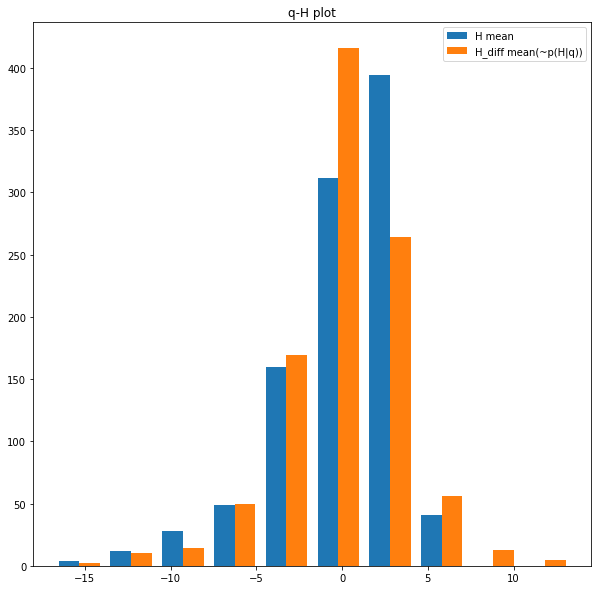

In [5]:
#E-BFMI指標となる (E(n)-E(n-1)) とE-mean(E)のヒストグラムをプロット
#https://arxiv.org/pdf/1701.02434.pdf のP45. Fig.34を作るのとほぼ同じはず。
#モデルが_normalのときはほぼ一致、_expのときは乖離するのが観察できる
#モデルの線形な歪み(M)は影響しないっぽい
p_end=  np.array(ret,dtype=np.float)[:,1,-1,:]
q_end=  np.array(ret,dtype=np.float)[:,0,-1,:]
H_end=np.array([H(p,q) for q,p in zip(q_end,p_end)],dtype=np.float)

plt.figure(figsize=(10,10))
plt.title("q-H plot")

hd=H_end[1:]-H_end[:-1]

plt.hist([H_end-np.mean(H_end), hd-np.mean(hd)],label=["H mean","H_diff mean(~p(H|q))"])
plt.legend()
